In [1]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle
from treeconfigparser import TreeConfigParser

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm
import matplotlib_functions
matplotlib_functions.setMatplotlibParam()
plt.viridis()

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
from include.loss import pixel_weighted_cross_entropy
import dplume
import ddeq

import build_ds
import ddeq_pred

from ddeq_eval import get_mean_loss, shift_to_proba, get_all_loss
from scipy.optimize import differential_evolution

dir_eval_ddeq = "/libre/dumontj/coco2/ddeq/eval"
dir_plots = "/cerea_raid/users/dumontj/dev/coco2/dl/ddeq/fig"

Segmentation Models: using `keras` framework.


<Figure size 1800x1200 with 0 Axes>

In [3]:
PS = "Boxberg"
ds = xr.open_dataset(os.path.join(dir_eval_ddeq, 
                                  build_ds.get_abbrev_source(PS),
                                  "res_ddeq.nc"))
y_test = tf.convert_to_tensor(np.expand_dims(ds.weight_bool_plume.values, -1), np.float32) 

2022-10-19 11:13:53.482504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 11:13:53.928831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14674 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Baseline 1: score with best constant probability map

In [4]:
pred_test = 0.1*tf.ones(shape=y_test.shape)
res = differential_evolution(get_mean_loss, args=(y_test, pred_test), bounds = [[0,1], [0,1]])
[proba_min, proba_max] = res["x"]
loss_mean = res["fun"]

shifted_b1_pred_test = shift_to_proba(pred_test,proba_max,proba_min)

In [5]:
b1_all_loss_test = get_all_loss(y_test, shifted_b1_pred_test)
print("loss median:", np.median(b1_all_loss_test))
print("loss mean:", np.mean(b1_all_loss_test))

loss median: 0.54734117
loss mean: 0.5720303


In [6]:
t = np.random.choice(y_test.shape[0],1)[0]

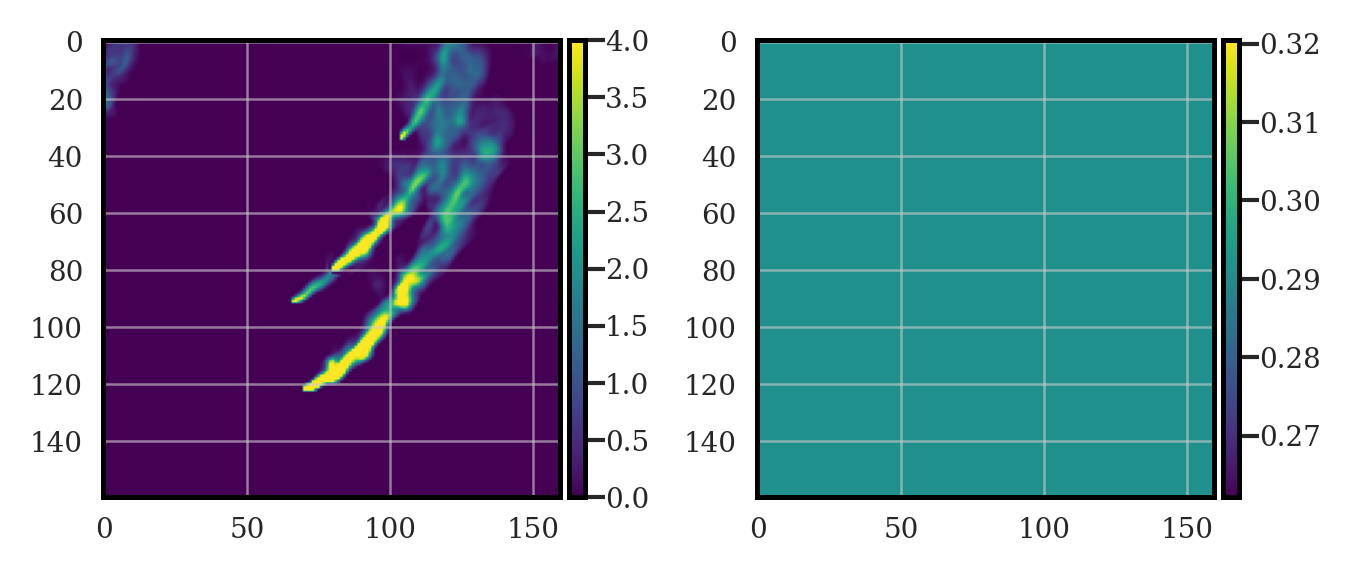

In [7]:
axs = matplotlib_functions.set_figure_axs(1,2, pad_w_ext_left=0.1, pad_w_ext_right=0.1, 
                                         pad_w_int=0.15, pad_h_ext=0.2, pad_h_int=0.15)

im0 = axs[0].imshow(y_test[t,:,:,0])
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
im1 = axs[1].imshow(shifted_b1_pred_test[0,:,:,0])
cax1 = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical")

In [1]:
df = pd.DataFrame({'loss': b1_all_loss_test})
matplotlib_functions.setMatplotlibParam_KdePlot()
ax = sns.kdeplot(
    data=df,
    x="loss",
    common_norm=False,
    fill=True,
    lw=1.2,
    alpha=0.4,
    levels=1,
    bw_adjust = 0.3, 
    palette="cmc.vikO", # batlowW, batlowW_r batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
plt.xlabel("Weighted binary cross-entropy loss", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.grid(linewidth=1., alpha=1)
matplotlib_functions.setMatplotlibParam()
plt.viridis()

NameError: name 'pd' is not defined

### Baseline 2: ddeq segmentation

In [9]:
pred_test = tf.convert_to_tensor(np.expand_dims(ds.ddeq_plumes.values, -1), np.float32) 
res = differential_evolution(get_mean_loss, args=(y_test, pred_test), bounds = [[0,1], [0,1]])
[proba_min, proba_max] = res["x"]
loss_mean = res["fun"]

shifted_b2_pred_test = shift_to_proba(pred_test,proba_max,proba_min)

In [10]:
b2_all_loss_test = get_all_loss(y_test, shifted_b2_pred_test)
print("loss median:", np.median(b2_all_loss_test))
print("loss mean:", np.mean(b2_all_loss_test))

loss median: 0.49914426
loss mean: 0.5217748


/cerea_raid/users/dumontj/dev/coco2/dl/ddeq/fig/ddeq_pred_Boxberg.png


<Figure size 1920x1440 with 0 Axes>

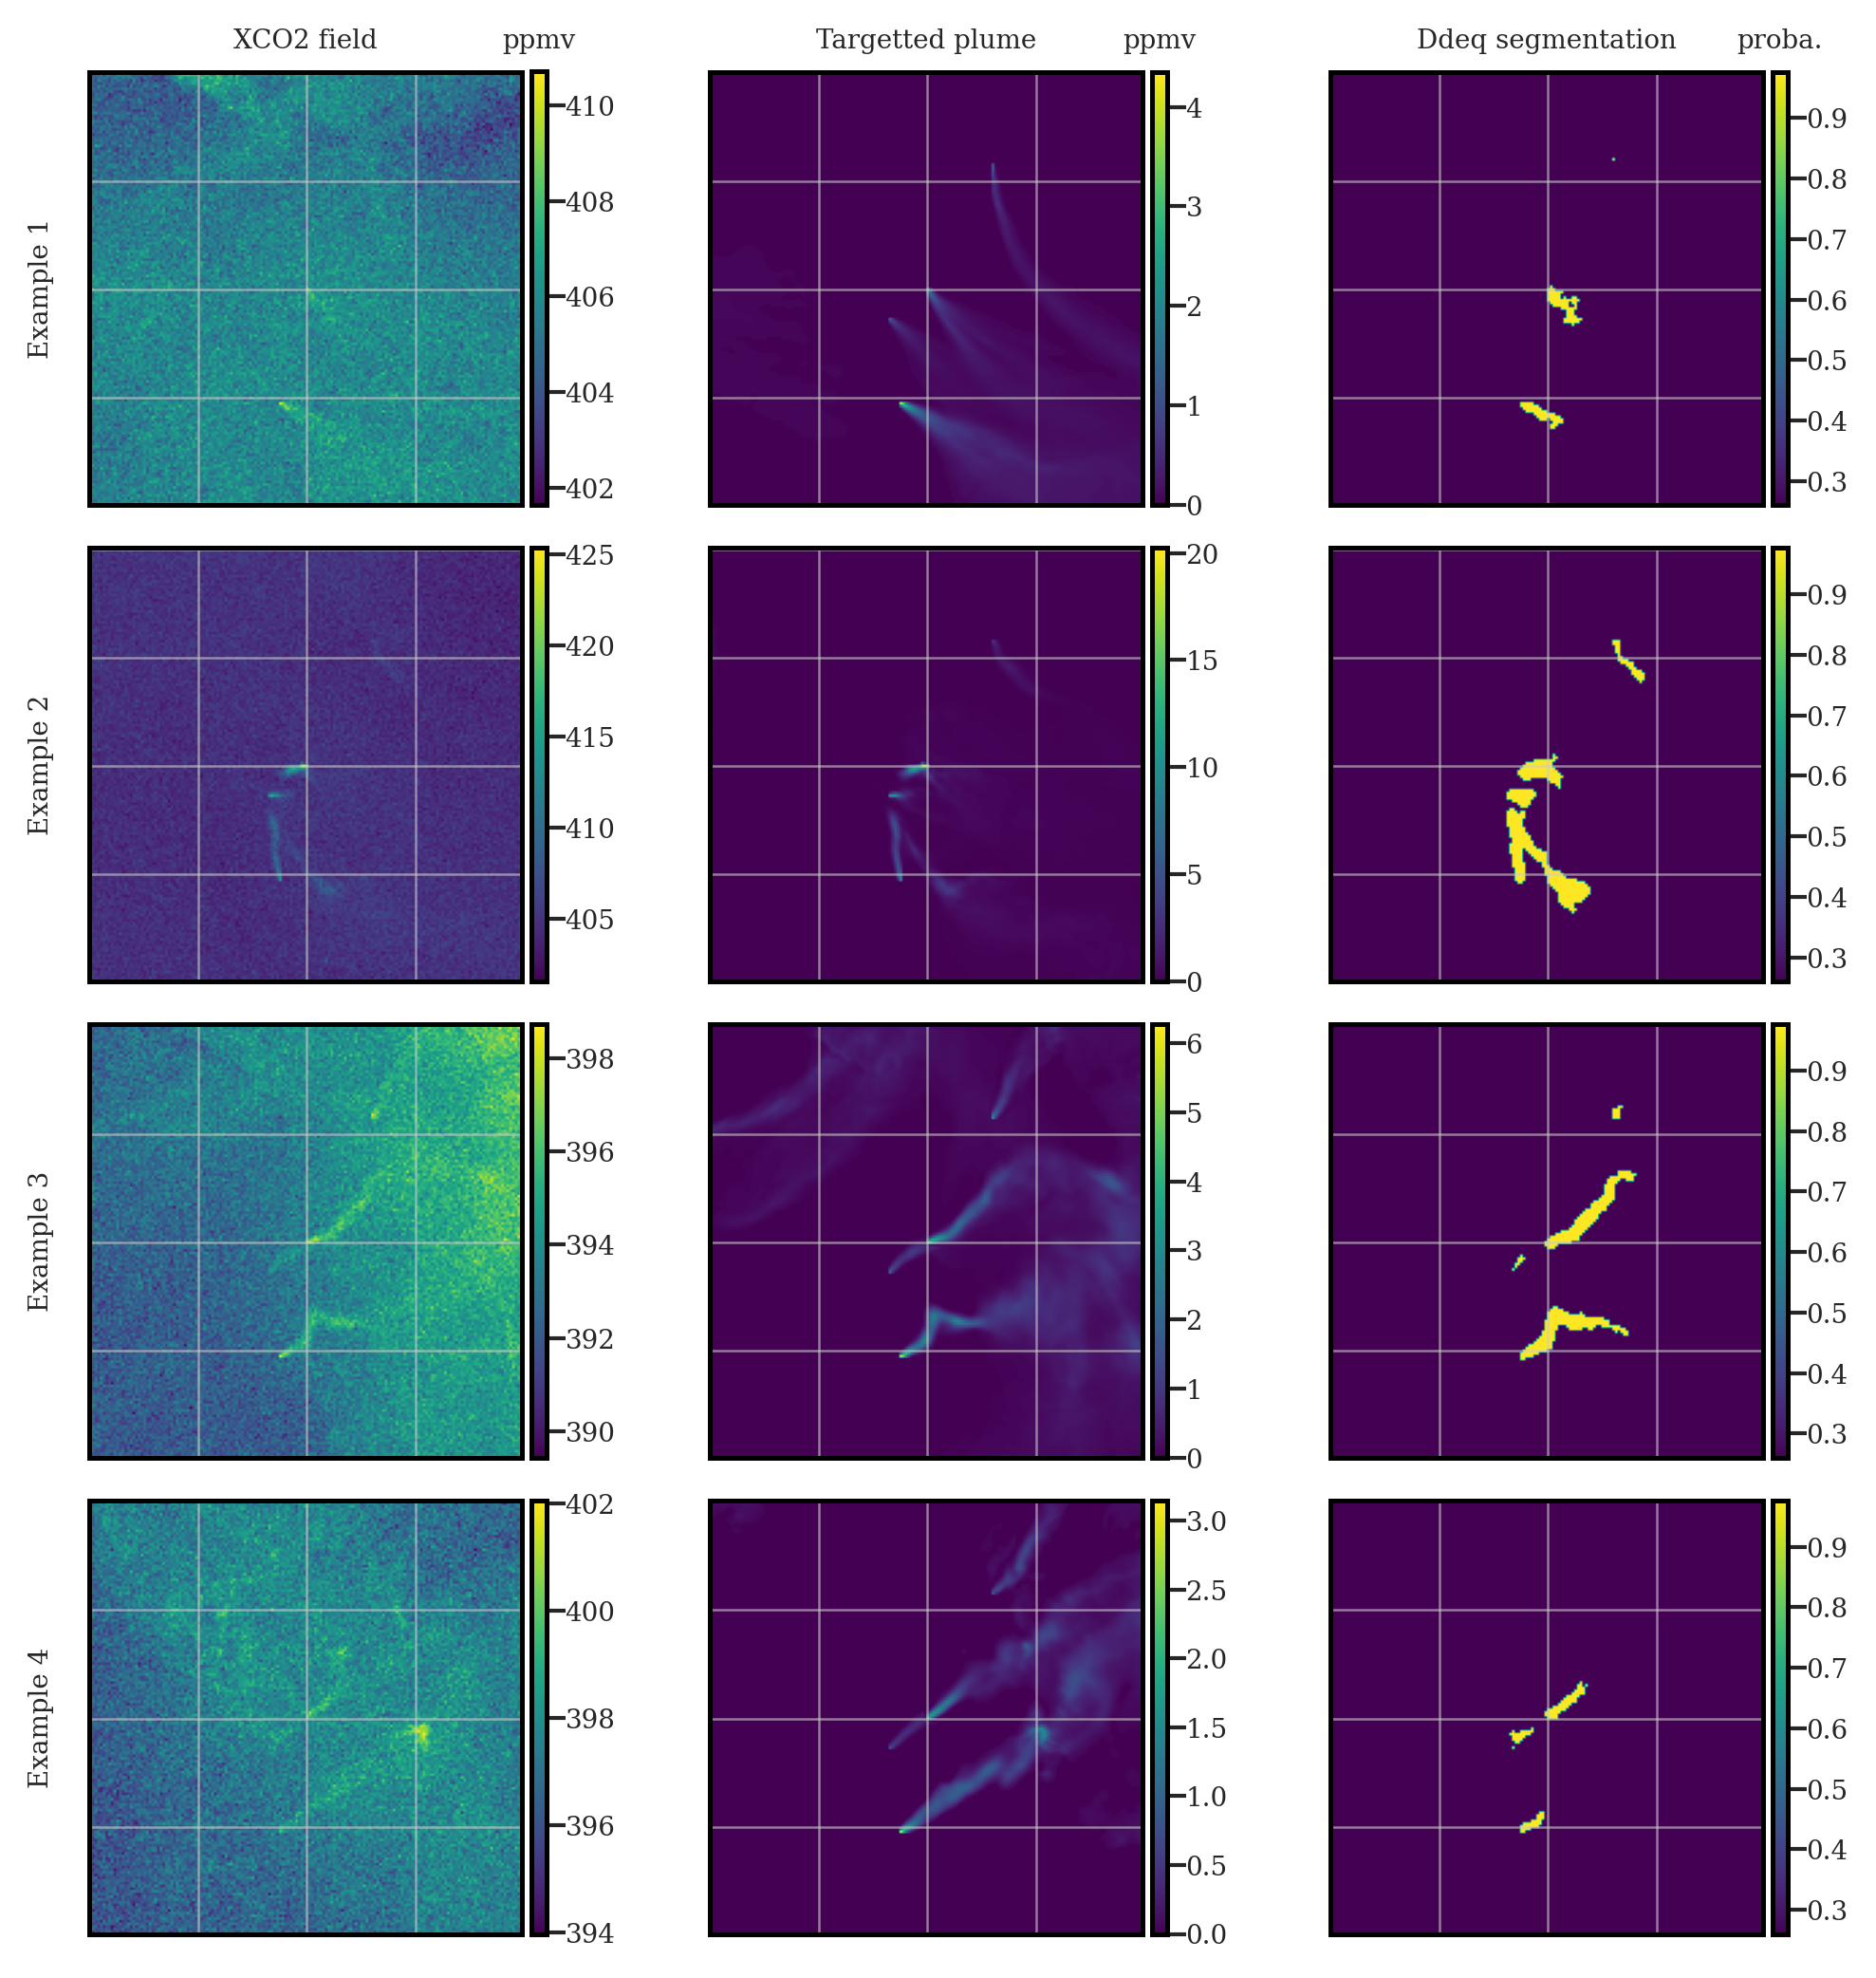

In [21]:
t1 = np.random.choice(y_test.shape[0],1)[0]
t2 = np.random.choice(y_test.shape[0],1)[0]
t3 = np.random.choice(y_test.shape[0],1)[0]
t4 = np.random.choice(y_test.shape[0],1)[0]
matplotlib_functions.setMatplotlibParam()

plt.viridis()
axs = matplotlib_functions.set_figure_axs(4,3, pad_w_ext_left=0.1, pad_w_ext_right=0.1, 
                                         pad_w_int=0.15, pad_h_ext=0.2, pad_h_int=0.15)
ims = [None]*(4*3)
caxs = [None]*(4*3)
cbars = [None]*(4*3)

for ax in axs:
    ax.set_xticks([0,40,80,120,160])
    ax.set_yticks([0,40,80,120,160])
    ax.set_xticklabels([])
    ax.set_yticklabels([])    

t = t1
i_ax = 0
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 1
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 2
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t2
i_ax = 3
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 4
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 5
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t3
i_ax = 6
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 7
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 8
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t4
i_ax = 9
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 10
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 11
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Ddeq segmentation")
axs[0].set_ylabel("Example 1")
axs[3].set_ylabel("Example 2")
axs[6].set_ylabel("Example 3")
axs[9].set_ylabel("Example 4")

cbars[0].ax.set_title("ppmv")
cbars[1].ax.set_title("ppmv")
cbars[2].ax.set_title("proba.")

name_plot = os.path.join(dir_plots, f"ddeq_pred_{PS}.png")
#plt.savefig(name_plot)
print(name_plot)

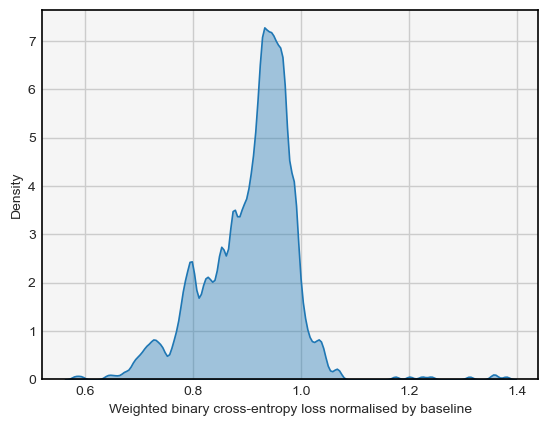

In [16]:
df = pd.DataFrame({'loss': b2_all_loss_test / b1_all_loss_test})
matplotlib_functions.setMatplotlibParam_KdePlot()
ax = sns.kdeplot(
    data=df,
    x="loss",
    common_norm=False,
    fill=True,
    lw=1.2,
    alpha=0.4,
    levels=1,
    bw_adjust = 0.3, 
    palette="cmc.vikO", # batlowW, batlowW_r batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
plt.xlabel("Weighted binary cross-entropy loss normalised by baseline", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.grid(linewidth=1., alpha=1)
matplotlib_functions.setMatplotlibParam()
plt.viridis()

## Plot baseline 1 and 2 and see

<Figure size 1920x1440 with 0 Axes>

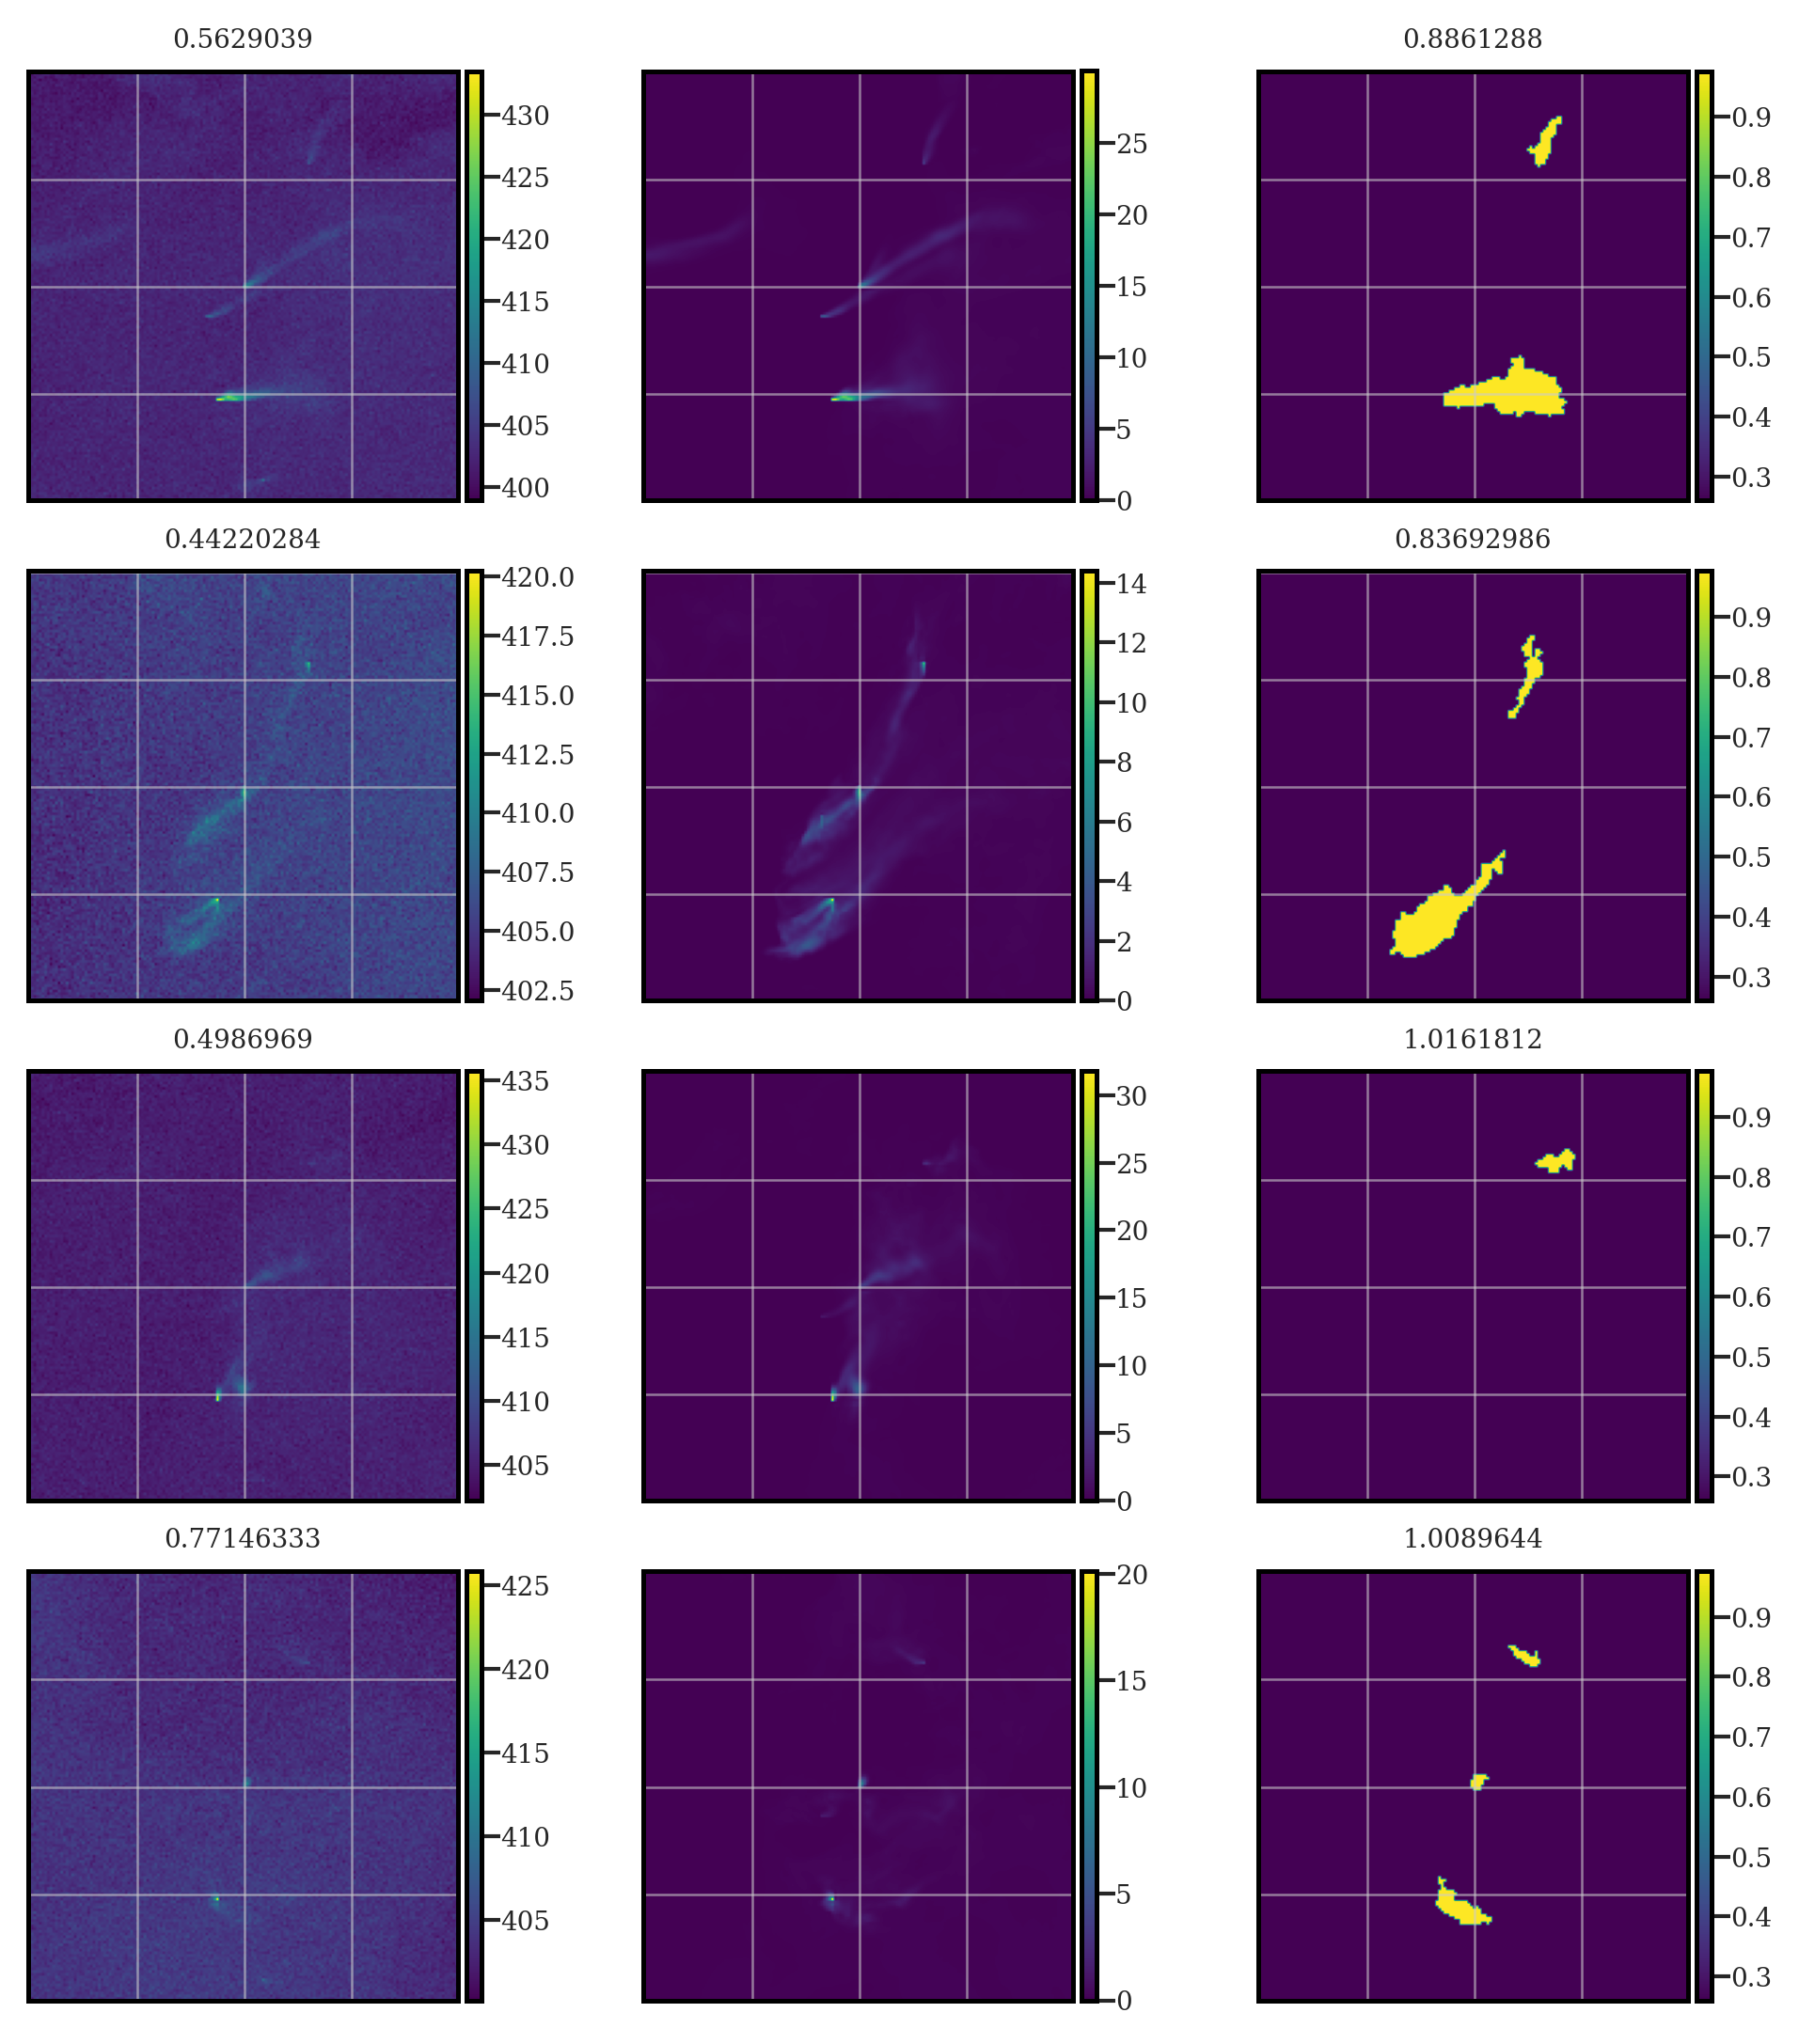

In [17]:
t1 = np.random.choice(y_test.shape[0],1)[0]
t2 = np.random.choice(y_test.shape[0],1)[0]
t3 = np.random.choice(y_test.shape[0],1)[0]
t4 = np.random.choice(y_test.shape[0],1)[0]

matplotlib_functions.setMatplotlibParam()

plt.viridis()
axs = matplotlib_functions.set_figure_axs(4,3, pad_w_ext_left=0.1, pad_w_ext_right=0.1, 
                                         pad_w_int=0.15, pad_h_ext=0.2, pad_h_int=0.25)
ims = [None]*(4*3)
caxs = [None]*(4*3)
cbars = [None]*(4*3)

for ax in axs:
    ax.set_xticks([0,40,80,120,160])
    ax.set_yticks([0,40,80,120,160])
    ax.set_xticklabels([])
    ax.set_yticklabels([])    

t = t1
i_ax = 0
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 1
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 2
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t2
i_ax = 3
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 4
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 5
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t3
i_ax = 6
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 7
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 8
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

t = t4
i_ax = 9
ims[i_ax] = axs[i_ax].imshow(ds.xco2_noisy.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 10
ims[i_ax] = axs[i_ax].imshow(ds.plume.values[t,:,:])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

i_ax = 11
ims[i_ax] = axs[i_ax].imshow(shifted_b2_pred_test[t,:,:,0])
caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

for i_ax, t in zip([0,3,6,9], [t1,t2,t3,t4]):
    axs[i_ax].set_title(b1_all_loss_test[t])
    
for i_ax, t in zip([2,5,8,11], [t1,t2,t3,t4]):
    axs[i_ax].set_title(b2_all_loss_test[t]/b1_all_loss_test[t])    